In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,jaccard_score,precision_score,recall_score

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import MaxPool2D, Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
from albumentations import HorizontalFlip,VerticalFlip, CoarseDropout,RandomBrightnessContrast,RandomContrast,PixelDropout,Rotate

In [ ]:
img_path = "/content/drive/MyDrive/images/entrenamiento"
mask_path = "/content/drive/MyDrive/images/mask_entrenamiento"
img_val_path = "/content/drive/MyDrive/images/val"
val_mask_path = "/content/drive/MyDrive/images/mask_val"
drive = "/content/drive/MyDrive/images"
logs = "/content/drive/MyDrive/images/logs"

height = 128
width = 128

In [ ]:
def load_dataset(path):
  images = sorted(glob(os.path.join(path,"entrenamiento","*")))
  masks = sorted(glob(os.path.join(path,"mask_entrenamiento","*")))
  return images,masks


In [ ]:
def load_dataset(path):
  images = sorted(glob(os.path.join(path,"images","*")))
  masks = sorted(glob(os.path.join(path,"mask_entrenamiento","*")))
  return images,masks

In [ ]:
images, masks = load_dataset(drive)
print(len(images), len(masks))

71 71


In [ ]:
!pip install imshowtools

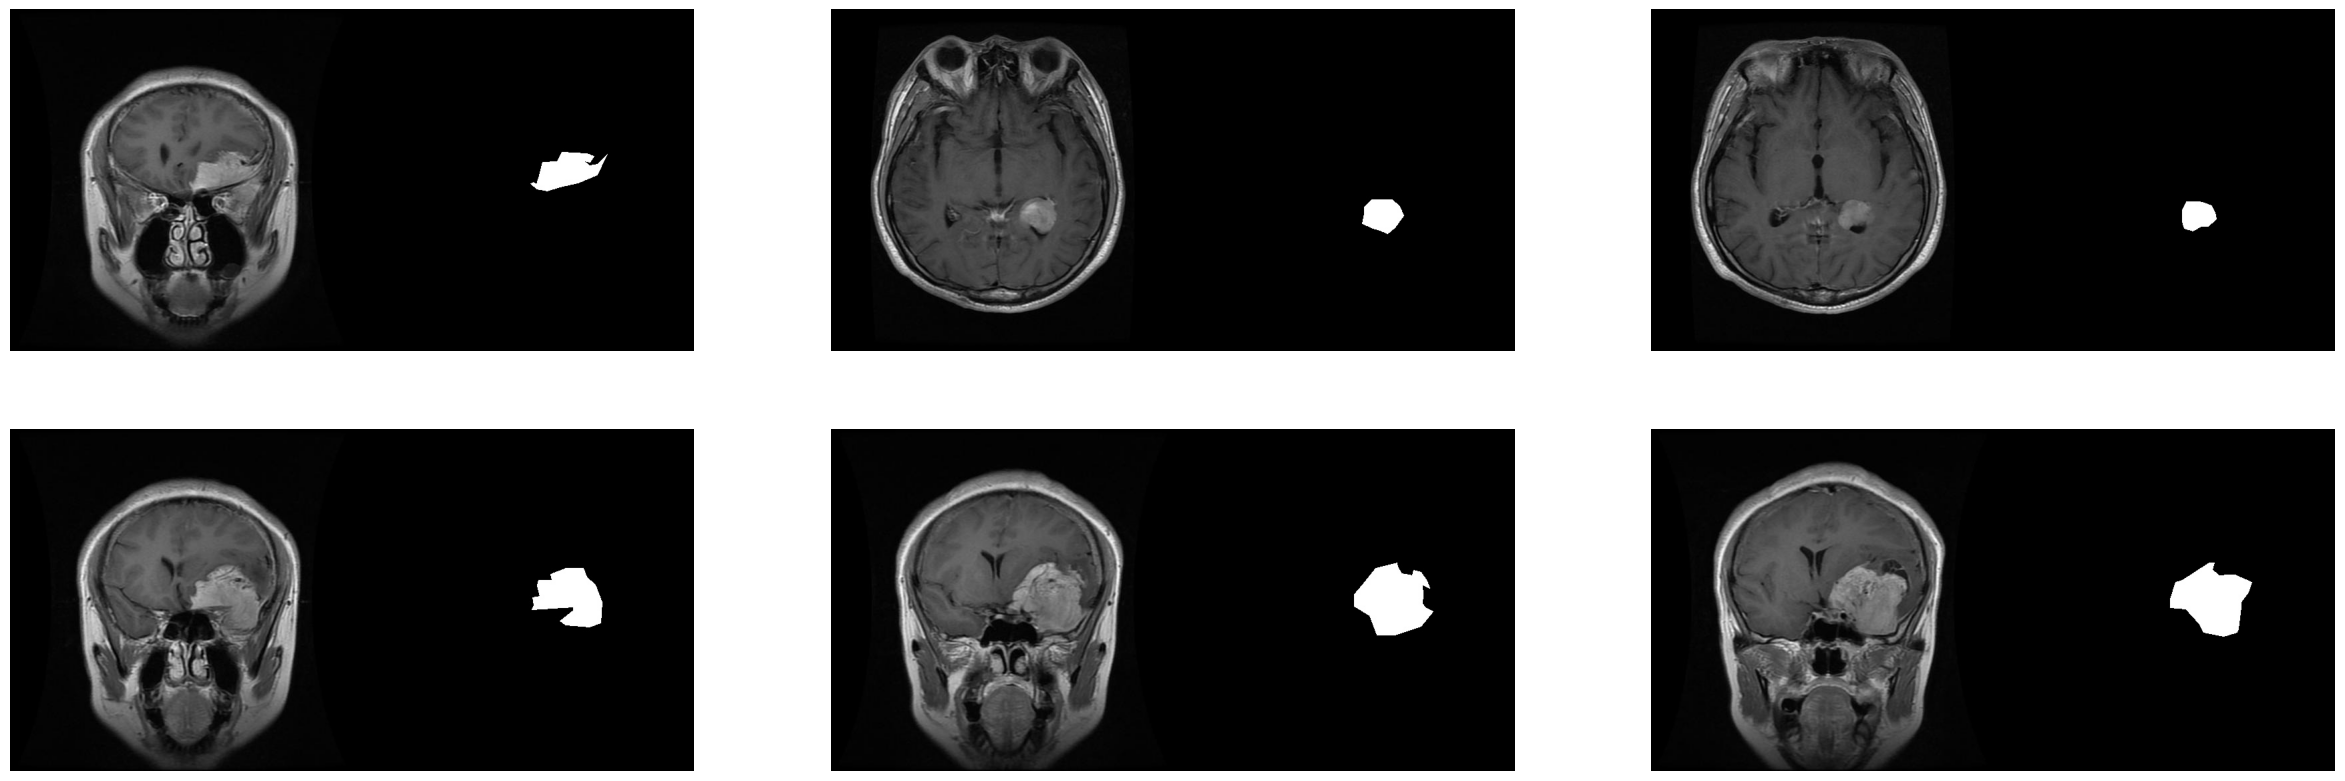

In [ ]:
from imshowtools import imshow
cat = []
for x,y in zip(images[:6],masks[:6]):
  x = cv2.imread(x,cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)

  y = cv2.imread(y,cv2.IMREAD_COLOR)

  z = np.concatenate([x,y],axis=1)
  cat.append(z)

imshow(*cat,size=(30,10),columns=3)

In [ ]:
def save_data(images, masks, save_dir):
    images_dir = os.path.join(save_dir, "images")
    masks_dir = os.path.join(save_dir, "masks")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = os.path.basename(x).split(".")[0]

        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented["image"]
        y1 = augmented["mask"]

        aug = CoarseDropout(p=1.0, max_holes=10, max_height=32, max_width=32)
        augmented = aug(image=x, mask=y)
        x2 = augmented["image"]
        y2 = augmented["mask"]

        aug = RandomBrightnessContrast(p=1.0)
        augmented = aug(image=x, mask=y)
        x3 = augmented["image"]
        y3 = augmented["mask"]

        aug = RandomContrast(p=1.0)
        augmented = aug(image=x, mask=y)
        x4 = augmented["image"]
        y4 = augmented["mask"]

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x5 = augmented["image"]
        y5 = augmented["mask"]

        aug = Rotate(p=1.0, limit=45)
        augmented = aug(image=x, mask=y)
        x6 = augmented["image"]
        y6 = augmented["mask"]

        aug = PixelDropout(p=1.0, dropout_prob=0.20)
        augmented = aug(image=x, mask=y)
        x7 = augmented["image"]
        y7 = augmented["mask"]

        aug_x = [x, x1, x2, x3, x4, x5, x6, x7]
        aug_y = [y, y1, y2, y3, y4, y5, y6, y7]

        for idx, (ax, ay) in enumerate(zip(aug_x, aug_y)):
            aug_name = f"{name}_{idx}.jpg"

            save_image_path = os.path.join(images_dir, aug_name)
            save_mask_path = os.path.join(masks_dir, aug_name)

            cv2.imwrite(save_image_path, ax)
            cv2.imwrite(save_mask_path, ay)

In [ ]:
#save_data(images,masks,drive)

  0%|          | 0/71 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


In [ ]:
def load_dataset(path):
  images = sorted(glob(os.path.join(path,"images","*")))
  masks = sorted(glob(os.path.join(path,"masks","*")))
  return images,masks

In [ ]:
images, masks = load_dataset(drive)
print(len(images), len(masks))

568 568


In [ ]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# Conv Blocks

In [ ]:
def conv_block(inputs,num_filters):
  x = Conv2D(num_filters,3,padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters,3,padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

In [ ]:
x = Input((128,128,3))
y = conv_block(x,64)
print(y.shape)

NameError: name 'Input' is not defined

# Encode Blocks


In [ ]:
def encoder_block(inputs,num_filters):
  x = conv_block(inputs,num_filters)
  p = MaxPooling2D((2,2))(x)

  return x,p

In [ ]:
x = Input((128,128,3))
s,p = encoder_block(x,64)
print(s.shape,p.shape)

(None, 128, 128, 64) (None, 64, 64, 64)


# Decoder Block


In [ ]:
def decoder_block(inputs,skip,num_filters):
  x = Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
  x = Concatenate()([x,skip])
  x = conv_block(x,num_filters)
  return x


In [ ]:
x = Input((128,128,3))
s = Input((256,256,3))
y = decoder_block(x,s,32)
print(y.shape)

(None, 256, 256, 32)


In [ ]:
def Unet(input_shape):
  """
  Input Layer
  """
  inputs = Input(input_shape)

  """
  Encoder Blocks
  """
  s1, p1 = encoder_block(inputs,64)
  s2, p2 = encoder_block(p1,128)
  s3, p3 = encoder_block(p2,256)
  s4, p4 = encoder_block(p3,512)

  """
  Bridge ConvBlock Encoder-Decoder
  """
  b1 = conv_block(p4,1024)

  """
  Decoder Blocks
  """

  d1 = decoder_block(b1,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  """
  Output
  """
  outputs = Conv2D(1,1,padding="same",activation="sigmoid")(d4)

  model = Model(inputs,outputs,name="Unet")
  return model

In [ ]:
input_shape = (128,128,3)
model = Unet(input_shape)

In [ ]:
model.summary()

In [ ]:
def load_data(path):
  images = sorted(glob(os.path.join(path,"images","*")))
  masks = sorted(glob(os.path.join(path,"masks","*")))

  return images,masks

In [ ]:
images, masks= load_data(drive)

In [ ]:
def cargar_imagenes(ruta_imagenes, tamaño=(128,128)):
    imagenes = []

    for filename in os.listdir(ruta_imagenes):
        ruta_imagen = os.path.join(ruta_imagenes, filename)

        imagen = cv2.imread(ruta_imagen)
        imagen = cv2.resize(imagen, tamaño)  # Reescalar la imagen al tamaño deseado
        imagen = imagen / 255.0  # Normalizar los valores de píxeles (0-255) al rango (0-1)
        imagenes.append(imagen)

    imagenes = np.array(imagenes)

    return imagenes

In [ ]:
def cargar_mascaras(ruta_mascaras, tamaño=(128,128)):
    mascaras = []

    for filename in os.listdir(ruta_mascaras):
        ruta_mascara = os.path.join(ruta_mascaras, filename)

        mascara = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)
        mascara = cv2.bitwise_not(mascara)
        mascara = cv2.resize(mascara, tamaño)  # Reescalar la máscara al tamaño deseado
        mascara = mascara / 255.0
        mascara = np.expand_dims(mascara,axis=-1)
        mascaras.append(mascara)

    mascaras = np.array(mascaras)

    return mascaras

In [ ]:
img_path = "/content/drive/MyDrive/images/images"
imagenes = cargar_imagenes(img_path)

In [ ]:
imagenes.shape

(568, 128, 128, 3)

In [ ]:
masks_path = "/content/drive/MyDrive/images/masks"
masks = cargar_mascaras(masks_path)

In [ ]:
masks.shape

(568, 128, 128, 1)

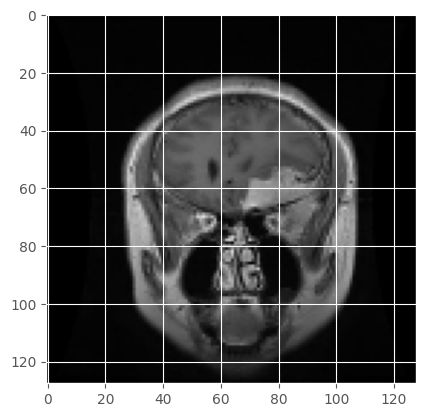

In [ ]:
plt.imshow(imagenes[0]);

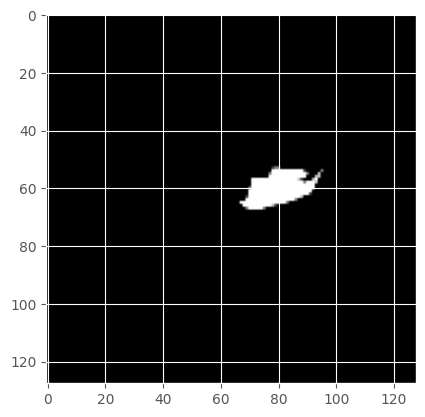

In [ ]:
plt.imshow(masks[0],cmap="binary");

In [ ]:
def split_data(images,masks):
  X_train, X_test,y_train, y_test= train_test_split(images, masks, test_size= 0.2 , shuffle = False, random_state = 42)
  return  X_train, X_test,y_train, y_test

In [ ]:
X_train, X_test,y_train, y_test = split_data(imagenes,masks)

In [ ]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((454, 128, 128, 3),
 (114, 128, 128, 3),
 (454, 128, 128, 1),
 (114, 128, 128, 1))

In [ ]:
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="max",verbose=1)
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


history = model.fit(X_train, y_train, batch_size=32, epochs=50,validation_data=(X_test,y_test),verbose=1,callbacks=[checkpoint])

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

4/4 [==============================] - 1s 125ms/step - loss: 0.0454 - accuracy: 0.9880
Test loss: 0.045408353209495544
Test accuracy: 0.9879568219184875


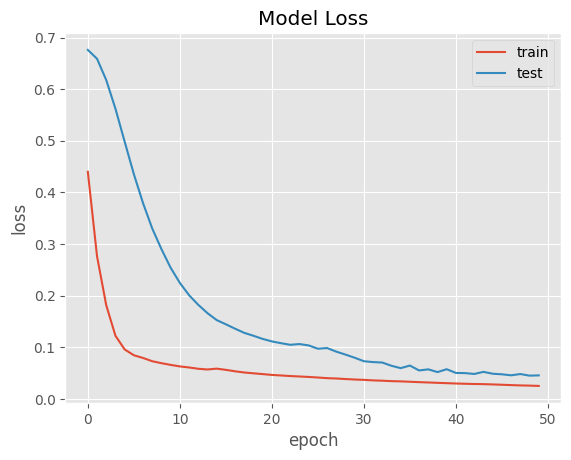

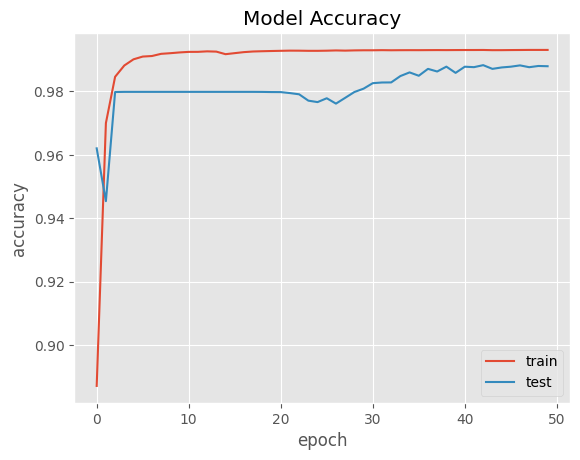

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.save("full_model.h5")

In [ ]:
h5_path= "/content/drive/MyDrive/images/full_model.h5"

In [ ]:
loaded_model = tf.keras.models.load_model(h5_path)

In [ ]:
loaded_model.summary()

In [ ]:
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

4/4 [==============================] - 21s 1s/step - loss: 0.0454 - accuracy: 0.9880
Test loss: 0.04540834575891495
Test accuracy: 0.9879568219184875


In [ ]:
test = "/content/drive/MyDrive/images/val"
predict = "/content/drive/MyDrive/images/predictions"

In [ ]:
test_x = sorted(glob(os.path.join(test,"*")))

In [ ]:
test_x

['/content/drive/MyDrive/images/val/m (158).jpg',
 '/content/drive/MyDrive/images/val/m (159).jpg',
 '/content/drive/MyDrive/images/val/m (160).jpg',
 '/content/drive/MyDrive/images/val/m (161).jpg',
 '/content/drive/MyDrive/images/val/m (162).jpg',
 '/content/drive/MyDrive/images/val/m (163).jpg',
 '/content/drive/MyDrive/images/val/m (164).jpg',
 '/content/drive/MyDrive/images/val/m (165).jpg',
 '/content/drive/MyDrive/images/val/m (166).jpg',
 '/content/drive/MyDrive/images/val/m (167).jpg',
 '/content/drive/MyDrive/images/val/m (168).jpg',
 '/content/drive/MyDrive/images/val/m (169).jpg',
 '/content/drive/MyDrive/images/val/m (170).jpg',
 '/content/drive/MyDrive/images/val/m (171).jpg',
 '/content/drive/MyDrive/images/val/m (172).jpg',
 '/content/drive/MyDrive/images/val/m (173).jpg']

In [ ]:
for i in tqdm(test_x):
  name = i.split("/")[-1]

  i = cv2.imread(i,cv2.IMREAD_COLOR)
  i = cv2.resize(i,(128,128))
  i = i / 255.0
  i = np.expand_dims(i,axis=0)

  p = loaded_model.predict(i)[0]
  p = p*255

  cv2.imwrite(os.path.join(predict,name),p)

  0%|          | 0/16 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 1/16 [00:00<00:02,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▎        | 2/16 [00:00<00:04,  2.93it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 3/16 [00:01<00:05,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 4/16 [00:01<00:04,  2.54it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 5/16 [00:02<00:05,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 6/16 [00:02<00:05,  1.91it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 7/16 [00:03<00:04,  1.85it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 8/16 [00:04<00:04,  1.64it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 9/16 [00:04<00:04,  1.67it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▎   | 10/16 [00:05<00:03,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 11/16 [00:05<00:02,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 12/16 [00:06<00:02,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 13/16 [00:06<00:01,  1.80it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 14/16 [00:07<00:01,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 15/16 [00:08<00:00,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]


In [ ]:
def load_dataset(path):
  images = sorted(glob(os.path.join(path,"val","*")))
  masks = sorted(glob(os.path.join(path,"predictions","*")))
  mask_val = sorted(glob(os.path.join(path,"mask_val","*")))
  return images,masks,mask_val

In [ ]:
images, masks,mask_val= load_dataset(drive)

In [ ]:
print(len(images),len(masks),len(mask_val))

16 16 16


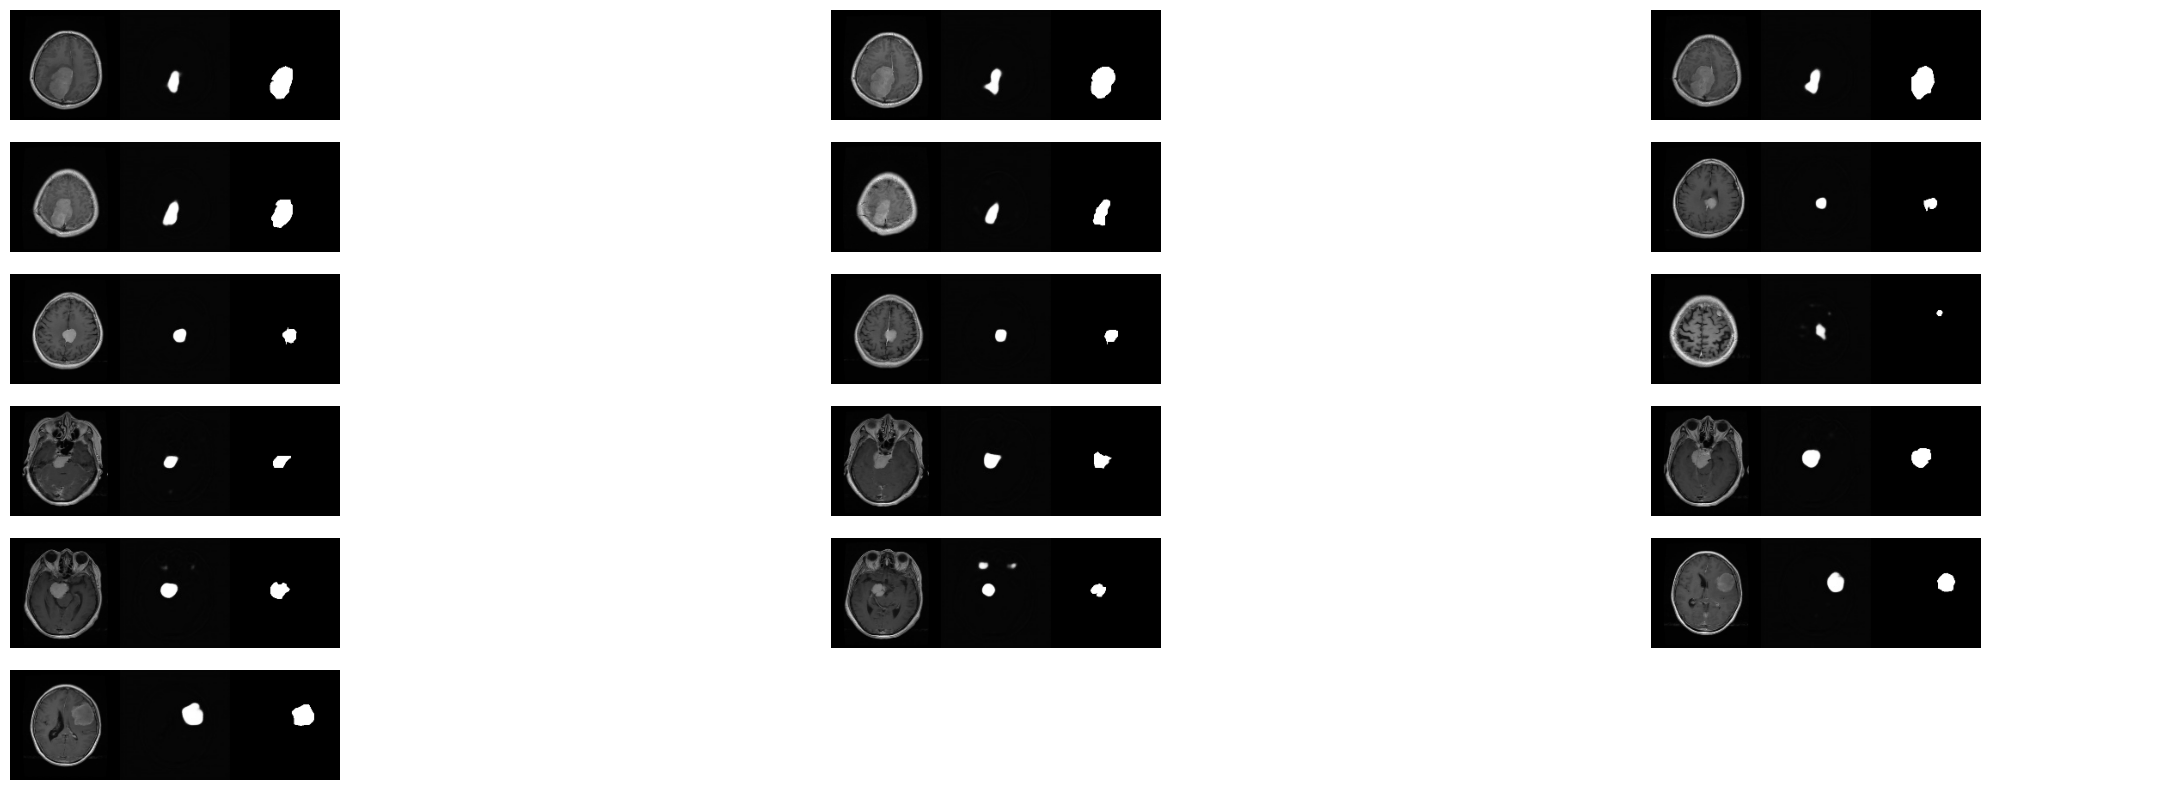

In [ ]:
from imshowtools import imshow
cat = []
for x,y,v in zip(images[:],masks[:],mask_val[:]):
  x = cv2.imread(x,cv2.IMREAD_COLOR)
  x = cv2.resize(x,(128,128))
  x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)

  y = cv2.imread(y,cv2.IMREAD_COLOR)
  y = cv2.bitwise_not(y)
  y = cv2.resize(y,(128,128))

  v = cv2.imread(v,cv2.IMREAD_COLOR)
  v = cv2.resize(v,(128,128))

  z = np.concatenate([x,y,v],axis=1)
  cat.append(z)

imshow(*cat,size=(30,10),columns=3)

In [ ]:
def load_dataset(path):
  masks = sorted(glob(os.path.join(path,"predictions","*")))
  mask_val = sorted(glob(os.path.join(path,"mask_val","*")))
  return masks,mask_val

In [ ]:
masks,mask_val= load_dataset(drive)

In [ ]:
print(masks[0],mask_val[0])

/content/drive/MyDrive/images/predictions/m (158).jpg /content/drive/MyDrive/images/mask_val/m (158).jpg


In [ ]:
score = []
iou_score = []
iou_score_tf = []
for pred_y,true_y in tqdm(zip(masks,mask_val),total=len(masks)):
  name = pred_y.split("/")[-1]
  pred_y = cv2.imread(pred_y,cv2.IMREAD_GRAYSCALE)
  pred_y = pred_y/255.0
  pred_y = pred_y > 0.5
  pred_y = pred_y.astype(np.int32)
  pred_y = pred_y.flatten()

  true_y = cv2.imread(true_y,cv2.IMREAD_GRAYSCALE)
  true_y = cv2.bitwise_not(true_y)
  true_y = cv2.resize(true_y,(128,128))
  true_y = true_y/255.0
  true_y = true_y > 0.5
  true_y = true_y.astype(np.int32)
  true_y = true_y.flatten()

  acc = accuracy_score(pred_y,true_y)
  f1 = f1_score(pred_y,true_y,labels=[0,1],average="binary")
  jac = jaccard_score(pred_y,true_y,labels=[0,1],average="binary")
  recall = recall_score(pred_y,true_y,labels=[0,1],average="binary")
  precision = precision_score(pred_y,true_y,labels=[0,1],average="binary")

  pred_y_tensor = tf.convert_to_tensor(pred_y)
  true_y_tensor = tf.convert_to_tensor(true_y)

  intersection = np.logical_and(pred_y, true_y).sum()
  union = np.logical_or(pred_y, true_y).sum()
  iou = intersection / union

  iou_tf = tf.keras.metrics.MeanIoU(num_classes=2)  # Num_classes es el número de clases incluyendo el fondo y el tumor
  iou_tf.update_state(true_y_tensor, pred_y_tensor)
  iou_result = iou_tf.result().numpy()

  iou_tf1 = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0,1])  # Num_classes es el número de clases incluyendo el fondo y el tumor
  iou_tf1.update_state(true_y_tensor, pred_y_tensor)
  iou_result1 = iou_tf1.result().numpy()

  score.append([name,acc,f1,jac,recall,precision])
  iou_score.append([name, iou])
  iou_score_tf.append([name, iou_result,iou_result1])

100%|██████████| 16/16 [00:01<00:00,  9.46it/s]


In [ ]:
score

In [ ]:
score = [s[1:] for s in score]

In [ ]:
score

In [ ]:
mean = np.mean(score,axis=0)

In [ ]:
print(f"ACC: {mean[0]}")
print(f"F1: {mean[1]}")
print(f"Jac: {mean[2]}")
print(f"Recall: {mean[3]}")
print(f"Precision: {mean[4]}")

ACC: 0.9902801513671875
F1: 0.9950104111179445
Jac: 0.9901214716193568
Recall: 0.9914469078631429
Precision: 0.9986686955299048


In [ ]:
iou_score

[['m (158).jpg', 0.9698791447164549],
 ['m (159).jpg', 0.9707511357271765],
 ['m (160).jpg', 0.9717696803880115],
 ['m (161).jpg', 0.9832409195688742],
 ['m (162).jpg', 0.9906507337006997],
 ['m (163).jpg', 0.9972938065071653],
 ['m (164).jpg', 0.9983328187712257],
 ['m (165).jpg', 0.9980282210857108],
 ['m (166).jpg', 0.989501953125],
 ['m (167).jpg', 0.9976556234190882],
 ['m (168).jpg', 0.9976463301331682],
 ['m (169).jpg', 0.995575221238938],
 ['m (170).jpg', 0.9967743936480368],
 ['m (171).jpg', 0.9926647352524194],
 ['m (172).jpg', 0.9969497011952191],
 ['m (173).jpg', 0.9952291274325172]]

In [ ]:
iou_score_tf

[['m (158).jpg', 0.65432733, 0.65432733],
 ['m (159).jpg', 0.6860125, 0.6860125],
 ['m (160).jpg', 0.6856203, 0.6856203],
 ['m (161).jpg', 0.7681985, 0.7681985],
 ['m (162).jpg', 0.79871076, 0.79871076],
 ['m (163).jpg', 0.86846936, 0.86846936],
 ['m (164).jpg', 0.93666637, 0.93666637],
 ['m (165).jpg', 0.9134526, 0.9134526],
 ['m (166).jpg', 0.49475098, 0.49475098],
 ['m (167).jpg', 0.90962595, 0.90962595],
 ['m (168).jpg', 0.9302311, 0.9302311],
 ['m (169).jpg', 0.9109906, 0.9109906],
 ['m (170).jpg', 0.91584754, 0.91584754],
 ['m (171).jpg', 0.7838324, 0.7838324],
 ['m (172).jpg', 0.9320792, 0.9320792],
 ['m (173).jpg', 0.92591643, 0.92591643]]

In [ ]:
iou = [s[1:] for s in iou_score_tf]

In [ ]:
iou

[[0.65432733, 0.65432733],
 [0.6860125, 0.6860125],
 [0.6856203, 0.6856203],
 [0.7681985, 0.7681985],
 [0.79871076, 0.79871076],
 [0.86846936, 0.86846936],
 [0.93666637, 0.93666637],
 [0.9134526, 0.9134526],
 [0.49475098, 0.49475098],
 [0.90962595, 0.90962595],
 [0.9302311, 0.9302311],
 [0.9109906, 0.9109906],
 [0.91584754, 0.91584754],
 [0.7838324, 0.7838324],
 [0.9320792, 0.9320792],
 [0.92591643, 0.92591643]]

In [ ]:
mean_iou = np.mean(iou,axis=0)

In [ ]:
mean_iou

array([0.8196708], dtype=float32)